# mlp reimplementation

Reproducing https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

Code written while following along with: https://www.youtube.com/watch?v=TCH_1BHY58I

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import string

stoi = {ch: i+1 for i, ch in enumerate(string.ascii_lowercase)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}

In [4]:
words = open('data/names.txt', 'r').read().splitlines()

In [5]:
#### Hyperparameters

# Num of features for each tri-gram embedding to learn
m_dim = 10

# possible characters, the vocabulary size, this isn't actually tuneable as its len(alphas) + 1 for delimiter
v = 27

# Number of neurons in hidden layer
h = 200

# This is n in the paper, the size of the "context" or look-back window
block_size = n = 3

In [6]:
#### Data prep

def build_dataset(in_words):
    # Create the dataset, where the inputs are a trigram context window -> outputs are the next character
    X, Y = [], []
    
    for w in in_words:
        w = w + '.'
        context = [0] * block_size
        for char in list(w):
            X.append(context)
            Y.append(stoi[char])
            context = context[1:] + [stoi[char]]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y


import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

In [111]:
#### Parameter initialization

# Embedding each character to 2-dimensional feature space
C = torch.rand((v, m_dim))

# Hidden layer weights and biases
W1 = torch.randn((block_size*m_dim, h)) * ((5/3) / ((block_size*m_dim)**0.5))
b1 = torch.randn(h) * 0.01

# Output layer weights and biases
W2 = torch.randn((h, v)) * 0.01
b2 = torch.randn(v) * 0

# Batchnorm gain and bias
bn_gain = torch.ones((1, h))
bn_bias = torch.zeros((1, h))
# Keep estimate of BatchNorm across entire training set (see later for explanation).
batch_mean_running = torch.zeros((1, h))
batch_std_running = torch.zeros((1, h))

for p in [C, W1, b1, W2, b2, bn_gain, bn_bias]:
    if not p.requires_grad:
        p.requires_grad = True

In [146]:
# Training loop
batch_size = 32

stepi = []
lossi = []
dead_neurons = []

for i in range(200000):
    # minibatch
    # select batch_size random indices from the training data
    idxs = torch.randint(0, X_train.shape[0], (batch_size,))
    idx = X_train[idxs]

    # Forward pass
    embedding = C[idx]
    pre_activation = embedding.view(-1, block_size*m_dim) @ W1 + b1

    # Batch normalization, make the pre_activation distribution for each neuron to be a gaussian
    batch_mean = pre_activation.mean(0, keepdim=True)
    batch_std = pre_activation.std(0, keepdim=True)
    pre_activation = bn_gain * (pre_activation - batch_mean) / batch_std + bn_bias

    # BatchNorm running mean/std over all data
    with torch.no_grad():
        gamma = 0.0001
        batch_mean_running = ((1 - gamma) * batch_mean_running) + (gamma * batch_mean)
        batch_std_running = ((1 - gamma) * batch_std_running) + (gamma * batch_std)

    # Non-linearity
    z1 = F.tanh(pre_activation) # (batch_size, h)
    # Output layer
    logits = z1 @ W2 + b2 # (batch_size, v)
    loss = F.cross_entropy(logits, Y_train[idxs])

    # Backward pass
    for params in [C, W1, b1, W2, b2, bn_gain, bn_bias]:
        params.grad = None

    loss.backward()

    learning_rate = 0.1
    dead = 0
    for p in [C, W1, b1, W2, b2, bn_gain, bn_bias]:
        dead += torch.sum((p.data == 0).int()).item()
        p.data += -learning_rate * p.grad

    dead_neurons.append(dead)
    stepi.append(i)
    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(f'Batch: {i}, training loss: {loss.item()}')

Batch: 0, training loss: 1.813681721687317
Batch: 10000, training loss: 2.112983465194702
Batch: 20000, training loss: 2.2902674674987793
Batch: 30000, training loss: 1.8632549047470093
Batch: 40000, training loss: 2.069182872772217
Batch: 50000, training loss: 1.8910508155822754
Batch: 60000, training loss: 1.986188292503357
Batch: 70000, training loss: 2.540534734725952
Batch: 80000, training loss: 1.8417359590530396
Batch: 90000, training loss: 2.210759162902832
Batch: 100000, training loss: 1.5098668336868286
Batch: 110000, training loss: 1.9481171369552612
Batch: 120000, training loss: 2.094052791595459
Batch: 130000, training loss: 2.122526168823242
Batch: 140000, training loss: 2.173058271408081
Batch: 150000, training loss: 2.011563777923584
Batch: 160000, training loss: 2.302095413208008
Batch: 170000, training loss: 1.9224581718444824
Batch: 180000, training loss: 2.1060218811035156
Batch: 190000, training loss: 2.2222321033477783


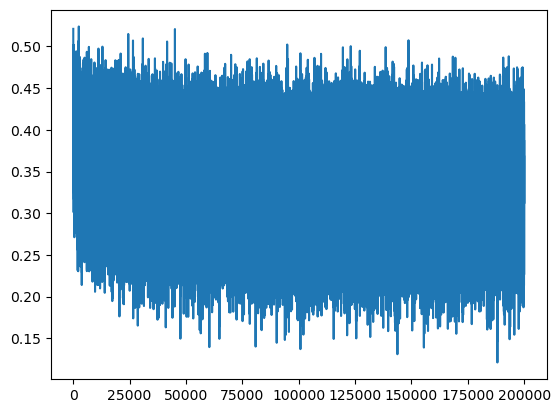

In [113]:
plt.plot(stepi, lossi)

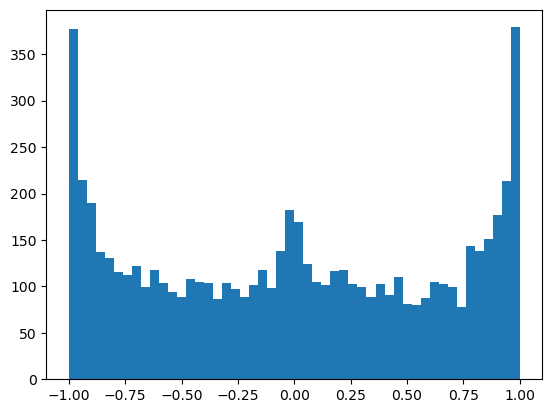

In [114]:
plt.hist(z1.view(-1).tolist(), 50);

In [115]:
@torch.no_grad()
def split_loss(split):
    data, labels = {
        'dev': (X_dev, Y_dev),
        'test': (X_test, Y_test),
    }[split]
    
    embedding = C[data]

    pre_activation = embedding.view(-1, block_size*m_dim) @ W1 + b1
    
    # Batch normalization
    batch_mean = pre_activation.mean(0, keepdim=True)
    batch_std = pre_activation.std(0, keepdim=True)
    pre_activation = bn_gain * ((pre_activation - batch_mean) / batch_std) + bn_bias
    
    z1 = F.tanh(pre_activation)
    logits = z1 @ W2 + b2
    loss = F.cross_entropy(logits, labels)
    print(f'{split} split loss: {loss}')

split_loss('dev')
split_loss('test')

dev split loss: 2.1512176990509033
test split loss: 2.1582329273223877


In [140]:
# The forward pass now expects batches of examples.
# How can we provide a meaningful value to the BatchNorm operation when we want
# to work with single examples for the case of generating outputs?

# Possible solutions:
#     1. Calibrate a batch norm across the entire training set, use these at generation time (see below)
#     2. Calculate an estimate for those values instead during training time


with torch.no_grad():
    emd = C[X_train]
    pre_activation = emd.view(-1, block_size*m_dim) @ W1 + b1
    bn_total_mean = pre_activation.mean(0, keepdim=True)
    bn_total_std = pre_activation.std(0, keepdim=True)

    #print(bn_total_mean, batch_mean_running)
    print(torch.allclose(bn_total_mean, batch_mean_running, atol=2e-01, rtol=2e-01))
    #torch.allclose(bn_total_std, batch_std_running, atol=1e-02, rtol=1e-01)

True


In [145]:
# Test it out

@torch.no_grad()
def out():
    for _ in range(10):
        out = []
        idx = 0
        context = [0] * block_size
        while True:
            emd = C[context].view((1, block_size*m_dim))

            pre_activation = emd @ W1 + b1
            pre_activation = bn_gain * ((pre_activation - batch_mean_running) / batch_std_running) + bn_bias
            
            z1 = F.tanh(pre_activation)
            z2 = F.softmax(z1 @ W2 + b2, dim=1)
            idx = torch.multinomial(z2, num_samples=1, replacement=True).item()
            out.append(itos[idx])
            context = context[1:] + [idx]
            if idx == 0:
                break
    
            # debug infinite loops...
            if len(out) > 10:
                break
        
        print(''.join(out))

out()

hesyn.
wylie.
lanyioniden
evona.
runyla.
tuan.
dhiaria.
bia.
jadi.
spa.
